## OptimESM: NEMO Pipeline Diagnostics

In [1]:
import glob
import xarray as xr
from nemo_cookbook import NEMODataTree

In [3]:
ds = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/SMHI/osnap/EC-Earth3-ESM-1_esm-up2p0_r1i1p1f1_osnap_1850-01-1899-12.nc")
ds

<xarray.Dataset> Size: 98MB
Dimensions:           (bdy: 68, time_counter: 600, k: 75)
Coordinates:
  * bdy               (bdy) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * time_counter      (time_counter) datetime64[ns] 5kB 1850-01-16T12:00:00 ....
  * k                 (k) int64 600B 1 2 3 4 5 6 7 8 ... 68 69 70 71 72 73 74 75
    glamb             (bdy) float64 544B ...
    gphib             (bdy) float64 544B ...
    depthb            (k, bdy) float64 41kB ...
Data variables:
    i_bdy             (bdy) float64 544B ...
    j_bdy             (bdy) float64 544B ...
    flux_type         (bdy) <U1 272B ...
    flux_dir          (bdy) int64 544B ...
    volume_transport  (time_counter, k, bdy) float64 24MB ...
    e1b               (bdy) float64 544B ...
    e3b               (time_counter, k, bdy) float64 24MB ...
    thetao            (time_counter, k, bdy) float64 24MB ...
    so                (time_counter, k, bdy) float64 24MB ...

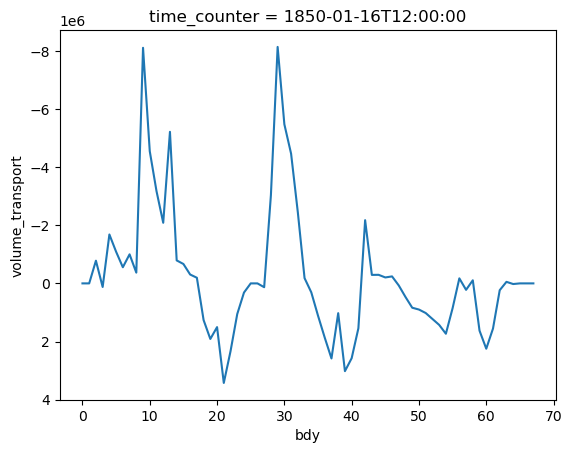

In [8]:
ds.volume_transport[0, :, :].sum(dim='k').plot(yincrease=False)

Text(0.5, 0, 'Time')

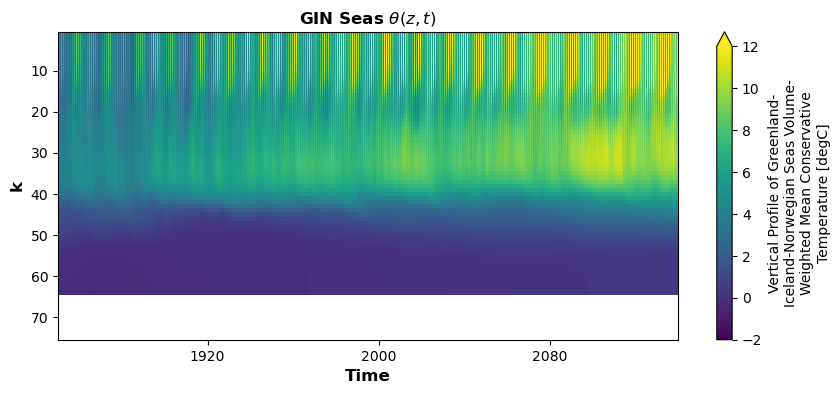

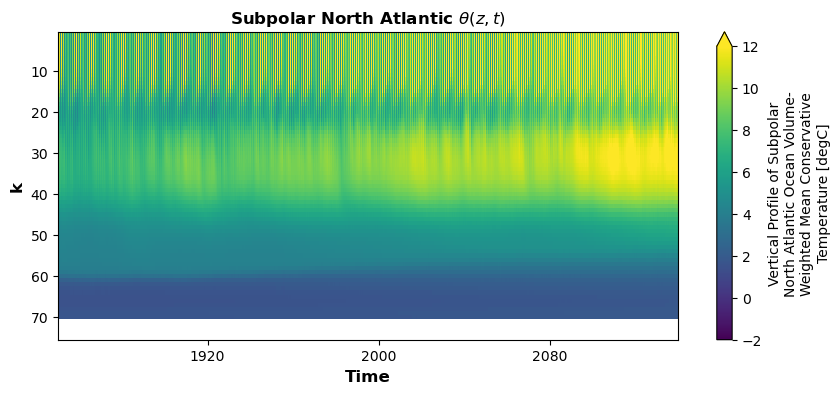

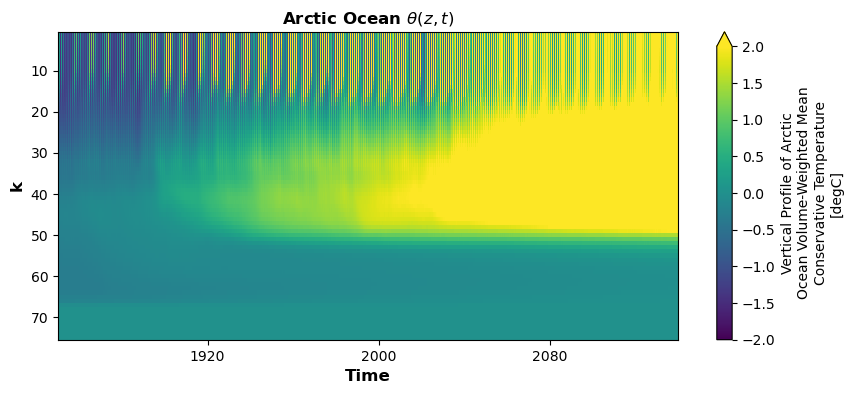

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
ds.thetao_con_GIN.plot(y='k', yincrease=False, cmap='viridis', vmin=-2, vmax=12)
plt.title('GIN Seas $\\theta(z, t)$', fontsize=12, fontweight='bold')
plt.ylabel('k', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')

plt.figure(figsize=(10, 4))
ds.thetao_con_SPNA.plot(y='k', yincrease=False, cmap='viridis', vmin=-2, vmax=12)
plt.title('Subpolar North Atlantic $\\theta(z, t)$', fontsize=12, fontweight='bold')
plt.ylabel('k', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')

plt.figure(figsize=(10, 4))
ds.thetao_con_AO.plot(y='k', yincrease=False, cmap='viridis', vmin=-2, vmax=2)
plt.title('Arctic Ocean $\\theta(z, t)$', fontsize=12, fontweight='bold')
plt.ylabel('k', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')

### UKESM1.2-LL - Sea Ice Area

In [ ]:
import glob

nemo_dir = "/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20250327/CMIP6/CMIP/MOHC/UKESM1-2/esm-up2p0-gwl2p0/r1i1p1f1/Omon"
filepath = f"{nemo_dir}/thetao/gn/v*/thetao_Omon_UKESM1-2-LL_esm-up2p0-gwl2p0_r1i1p1f1_gn_[20, 21, 22]*.nc"
if ("[" in filepath) and ("]" in filepath):
    substrings = filepath.split("[")[1].split("]")[0]
    filepaths = []
    for substr in substrings.replace(" ", "").split(","):
        filepaths.extend(glob.glob(filepath.replace(f"[{substrings}]", substr)))

filepaths

In [ ]:
# Define path to domain_cfg:
fpath = "/g100/home/userexternal/otooth00/OptimESM/data/CINECA/MOHC/UKESM1_Ofx/domain_cfg_Ofx_UKESM1.nc"
ds_domain = xr.open_dataset(fpath).rename({"z": "nav_lev"})

# Define path to eORCA1 monthly mean outputs:
exp_id="r1i1p1f1"
exp_name="esm-hist"
realm_name="SImon"
variable_name="siconc"
fdir=f"/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20240619/CMIP6/CMIP/MOHC/UKESM1-2/{exp_name}/{exp_id}/{realm_name}"
# fdir="/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20241218/CMIP6/CMIP/MOHC/UKESM1-2/${exp_name}/${exp_id}/{realm_name}"
fpaths_gridT=f"{fdir}/{variable_name}/gn/v*/{variable_name}_{realm_name}_UKESM1-2-LL_{exp_name}_{exp_id}_gn_*.nc"

# Define CFDatetimeCoder to decode time coords:
coder = xr.coders.CFDatetimeCoder(time_unit="s")
ds_icemod = xr.open_mfdataset(fpaths_gridT,
                             data_vars="minimal",
                             compat="no_conflicts",
                             decode_times=coder,
                             parallel=False,
                             engine="netcdf4"
                            )

ds_icemod = ds_icemod.rename({"i": "x",
                              "j": "y",
                              "time": "time_counter"
                              })

ds_icemod

In [ ]:
fpaths_gridT

In [ ]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent":
            {"domain": ds_domain,
             "icemod": ds_icemod,
             }
            }

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

In [ ]:
# Define Arctic Sea Ice regional bounding box:
bbox = (-180, 180, 45, 90)
nemo_nh = nemo.clip_grid(grid='/gridT', bbox=bbox)

if nemo_nh['/gridT']['siconc'].units == '%':
    nemo_nh['/gridT']['siarea'] = (nemo_nh.integral(grid='/gridT', var='siconc', dims=['i', 'j']) / 100)
else:
    nemo_nh['/gridT']['siarea'] = nemo_nh.integral(grid='/gridT', var='siconc', dims=['i', 'j'])

ds_out = nemo_nh['gridT']['siarea'].to_dataset(name='siarea_NH')

ds_out['siarea_NH'].attrs['standard_name'] = 'total_nh_sea_ice_area'
ds_out['siarea_NH'].attrs['long_name'] = 'Total Sea-Ice Area (Ocean Grid) in Northern Hemisphere'
ds_out['siarea_NH'].attrs['comment'] = 'Total grid cell area covered by sea ice (45-90 degN)'
ds_out['siarea_NH'].attrs['units'] = 'm2'

ds_out

In [ ]:
# Define Arctic Sea Ice regional bounding box:
bbox = (-180, 180, -90, -60)
nemo_sh = nemo.clip_grid(grid='/gridT', bbox=bbox)

if nemo_sh['/gridT']['siconc'].units == '%':
    ds_out['siarea_SH'] = (nemo_sh.integral(grid='/gridT', var='siconc', dims=['i', 'j']) / 100)
else:
    ds_out['siarea_SH'] = nemo_sh.integral(grid='/gridT', var='siconc', dims=['i', 'j'])

ds_out['siarea_SH'].attrs['standard_name'] = 'total_sh_sea_ice_area'
ds_out['siarea_SH'].attrs['long_name'] = 'Total Sea-Ice Area (Ocean Grid) in Southern Hemisphere'
ds_out['siarea_SH'].attrs['comment'] = 'Total grid cell area covered by sea ice (60-90 degS)'
ds_out['siarea_SH'].attrs['units'] = 'm2'

ds_out

In [ ]:
def compute_sea_ice_area(
    nemo: NEMODataTree,
    units: str = 'fraction'
) -> xr.Dataset:
    """
    Compute the total ocean grid cell area covered by sea ice.

    Time-series are computed for the Northern (45-90N) and
    Southern (60-90S) Hemispheres.

    Parameters:
    -----------
    nemo : NEMODataTree
        NEMODataTree object containing the model data.
    units: str, optional
        Unit of sea ice concentration variable. Options are:
        'fraction' or 'percentage'.

    Returns:
    --------
    xr.Dataset
        Total sea ice area time series for each hemisphere.
    """
    # -- Compute Total Sea-Ice Areas -- #
    # Apply Northern Hemisphere regional bounding box:
    bbox = (-180, 180, 45, 90)
    nemo_nh = nemo.clip_grid(grid='/gridT', bbox=bbox)

    # Apply Southern Hemisphere regional bounding box:
    bbox = (-180, 180, -90, -60)
    nemo_sh = nemo.clip_grid(grid='/gridT', bbox=bbox)

    # Compute total sea ice area by area-integration:
    if units == 'percentage':
        siarea_NH = (nemo_nh.integral(grid='/gridT', var='siconc', dims=['i', 'j']) / 100)
        siarea_SH = (nemo_sh.integral(grid='/gridT', var='siconc', dims=['i', 'j']) / 100)

    elif units == 'fraction':
        siarea_NH = nemo_nh.integral(grid='/gridT', var='siconc', dims=['i', 'j'])
        siarea_SH = nemo_sh.integral(grid='/gridT', var='siconc', dims=['i', 'j'])

    else:
        raise ValueError(f"Unsupported units for sea ice concentration: {units}")

    # -- Prepare Diagnostic Dataset -- #
    # Create Dataset for total sea ice area time-series:
    ds_out = siarea_NH.to_dataset(name='siarea_NH')
    ds_out['siarea_SH'] = siarea_SH

    # Update variable CF attributes:
    ds_out['siarea_NH'].attrs['standard_name'] = 'total_nh_sea_ice_area'
    ds_out['siarea_NH'].attrs['long_name'] = 'Total Sea-Ice Area (Ocean Grid) in Northern Hemisphere'
    ds_out['siarea_NH'].attrs['comment'] = 'Total grid cell area covered by sea ice (45-90 degN)'
    ds_out['siarea_NH'].attrs['units'] = 'm2'

    ds_out['siarea_SH'].attrs['standard_name'] = 'total_sh_sea_ice_area'
    ds_out['siarea_SH'].attrs['long_name'] = 'Total Sea-Ice Area (Ocean Grid) in Southern Hemisphere'
    ds_out['siarea_SH'].attrs['comment'] = 'Total grid cell area covered by sea ice (60-90 degS)'
    ds_out['siarea_SH'].attrs['units'] = 'm2'

    return ds_out


In [ ]:
compute_sea_ice_area(nemo, units='percentage')['siarea_NH'].plot()

In [ ]:
compute_sea_ice_area(nemo, units='percentage')['siarea_SH'].plot()

### UKESM1.2-LL - Mixed Layer Diagnostics

In [ ]:
# Define path to domain_cfg:
fpath = "/g100/home/userexternal/otooth00/OptimESM/data/CINECA/MOHC/UKESM1_Ofx/domain_cfg_Ofx_UKESM1.nc"
ds_domain = xr.open_dataset(fpath).rename({"z": "nav_lev"})

# Define path to eORCA1 monthly mean outputs:
exp_id="r1i1p1f1"
exp_name="esm-hist"
realm_name="Omon"
variable_name="thetao"
fdir=f"/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20240619/CMIP6/CMIP/MOHC/UKESM1-2/{exp_name}/{exp_id}/{realm_name}"
fpaths_gridT=f"{fdir}/{variable_name}/gn/v*/{variable_name}_{realm_name}_UKESM1-2-LL_{exp_name}_{exp_id}_gn_*.nc"

# Define CFDatetimeCoder to decode time coords:
coder = xr.coders.CFDatetimeCoder(time_unit="s")
ds_gridT = xr.open_mfdataset(fpaths_gridT,
                             data_vars="minimal",
                             compat="no_conflicts",
                             decode_times=coder,
                             parallel=False,
                             engine="netcdf4"
                            )

ds_gridT = ds_gridT.rename({"i": "x",
                            "j": "y",
                            "lev": "deptht",
                            "time": "time_counter"
                            })

# Define path to eORCA1 monthly mean outputs:
exp_id="r1i1p1f1"
exp_name="esm-hist"
realm_name="Omon"
variable_name="thkcello"
fdir=f"/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20240619/CMIP6/CMIP/MOHC/UKESM1-2/{exp_name}/{exp_id}/{realm_name}"
fpaths_thkcello=f"{fdir}/{variable_name}/gn/v*/{variable_name}_{realm_name}_UKESM1-2-LL_{exp_name}_{exp_id}_gn_*.nc"

# Define CFDatetimeCoder to decode time coords:
coder = xr.coders.CFDatetimeCoder(time_unit="s")
ds_thkcello = xr.open_mfdataset(fpaths_thkcello,
                                data_vars="minimal",
                                compat="no_conflicts",
                                decode_times=coder,
                                parallel=False,
                                engine="netcdf4"
                                )

ds_thkcello = ds_thkcello.rename({"i": "x",
                                  "j": "y",
                                  "lev": "deptht",
                                  "time": "time_counter"
                                  })

# Define path to eORCA1 monthly mean outputs:
exp_id="r1i1p1f1"
exp_name="esm-hist"
realm_name="Omon"
variable_name="so"
fdir=f"/g100_store/DRES_OptimESM/ESGF/prepub/mohc/20240619/CMIP6/CMIP/MOHC/UKESM1-2/{exp_name}/{exp_id}/{realm_name}"
fpaths_gridS=f"{fdir}/{variable_name}/gn/v*/{variable_name}_{realm_name}_UKESM1-2-LL_{exp_name}_{exp_id}_gn_*.nc"

# Define CFDatetimeCoder to decode time coords:
coder = xr.coders.CFDatetimeCoder(time_unit="s")
ds_gridS = xr.open_mfdataset(fpaths_gridS,
                             data_vars="minimal",
                             compat="no_conflicts",
                             decode_times=coder,
                             parallel=False,
                             engine="netcdf4"
                            )

ds_gridS = ds_gridS.rename({"i": "x",
                            "j": "y",
                            "lev": "deptht",
                            "time": "time_counter"
                            })

ds_gridT['so'] = ds_gridS['so']
ds_gridT['e3t'] = ds_thkcello['thkcello']
ds_gridT

In [ ]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent":
            {"domain": ds_domain,
             "gridT": ds_gridT,
             }
            }

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

In [ ]:
filedir = "/g100/home/userexternal/otooth00/OptimESM/data/CINECA"
filepath = f"{filedir}/MOHC/UKESM1_Ofx/regional_masks_Ofx_UKESM1-2.nc"
ds_mask = xr.open_dataset(filepath)

SPNA_mask = ds_mask['spnamsk']

thetao = nemo['gridT']['thetao'].where(nemo['gridT']['tmask'])
areacello = nemo.cell_area(grid="gridT", dim="k").where(nemo['gridT']['tmask'])
areacello = areacello.where(SPNA_mask, drop=True).fillna(0)

thetao_profile = thetao.where(SPNA_mask, drop=True).weighted(areacello).mean(dim=['i', 'j'])

thetao_profile

In [ ]:
thetao_profile = thetao.where(SPNA_mask, drop=True).weighted(areacello).mean(dim=['i', 'j'])
thetao_profile.isel(time_counter=slice(None, 24)).plot(y='k', yincrease=False)

In [ ]:
import gsw
import matplotlib.pyplot as plt

p = gsw.conversions.p_from_z(z= -nemo['gridT']['deptht'], lat=nemo['gridT']['gphit'])
SA = gsw.conversions.SA_from_SP(SP=nemo['gridT']['so'], p=p, lon=nemo['gridT']['glamt'], lat=nemo['gridT']['gphit'])
CT = gsw.conversions.CT_from_pt(SA=SA, pt=nemo['gridT']['thetao'])

# Seawater heat capacity - TEOS-10 [J kg-1 degC-1]
cp = 3991.86795711963
# Seawater reference density [kg m-3]
rho0 = 1025

thetao_con = CT.where(nemo['gridT']['tmask'])
volcello = nemo.cell_volume(grid="gridT").where(nemo['gridT']['tmask'])
volcello = volcello.where(SPNA_mask, drop=True)

volcello_profile = volcello.sum(dim=['i', 'j'])
ohc_profile = (thetao.where(SPNA_mask, drop=True)).weighted(volcello.fillna(0)).sum(dim=['i', 'j'])
ohc_profile

In [ ]:
(ohc_profile.isel(time_counter=slice(None, 24)) / (volcello_profile)).plot(y='k', yincrease=False)

plt.figure()
CT_profile = CT.where(SPNA_mask, drop=True).weighted(areacello).mean(dim=['i', 'j'])
CT_profile.isel(time_counter=slice(None, 24)).plot(y='k', yincrease=False)

plt.figure()
(CT.where(SPNA_mask, drop=True)).weighted(volcello.fillna(0)).mean(dim=['i', 'j']).isel(time_counter=slice(None, 24)).plot(y='k', yincrease=False)

In [ ]:
def compute_mixed_layer_diags(
    nemo: NEMODataTree,
    model_name: str = 'UKESM1-2-LL'
) -> xr.Dataset:
    """
    Compute the total mixed layer volume and area-weighted
    average mixed layer depth.

    Time-series are computed for the subpolar North Atlantic,
    Labrador Sea and GIN Seas defined using pre-defined World
    Seas IHO v3 regional definitions.

    Parameters:
    -----------
    nemo : NEMODataTree
        NEMODataTree object containing the model data.
    model_name: str, optional
        Name of OptimESM ESM. Options are: 'UKESM1-2-LL'
        'EC-Earth3-ESM-1', 'IPSL-CM6-ESMCO2', 'CNRM-ESM2-1'.

    Returns:
    --------
    xr.Dataset
        Total mixed layer volume and area-weighted average
        mixed layer depth time series for each region.
    """
    # -- Get World Seas IHO v3 masks -- #
    # Open pre-computed mask dataset:
    filedir = "/g100_work/optim_IAC/research/noc/otooth/OptimESM_IHO/masks"
    if model_name == 'UKESM1-2-LL':
        filepath = f"{filedir}/UKESM1-2_World_Seas_IHO_v3_mask.nc"
    elif model_name == "EC-Earth3-ESM-1":
        filepath = f"{filedir}/EC-Earth3-ESM-1_World_Seas_IHO_v3_mask.nc"
    elif model_name == "IPSL-CM6-ESMCO2":
        filepath = f"{filedir}/IPSL-CM6-ESMCO2_World_Seas_IHO_v3_mask.nc"
    elif model_name == 'CNRM-ESM2-1':
        filepath = f"{filedir}/CNRM-ESM2-1_World_Seas_IHO_v3_mask.nc"
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Open World Seas IHO v3 masks:
    ds_mask = xr.open_dataset(filepath).rename({'y': 'j', 'x': 'i'})

    # -- Prepare Input Variables -- #
    # Get mask ID (integer) for SPNA regions:
    NA_id = ds_mask["id"][ds_mask["name_iho"] == "North Atlantic Ocean"]
    LS_id = ds_mask["id"][ds_mask["name_iho"] == "Labrador Sea"]
    DS_id = ds_mask["id"][ds_mask["name_iho"] == "Davis Strait"]
    GS_id = ds_mask["id"][ds_mask["name_iho"] == "Greenland Sea"]
    NS_id = ds_mask["id"][ds_mask["name_iho"] == "Norwegian Sea"]

    # Define World Seas IHO v3 mask arrays:
    NA_mask = (ds_mask["mask_iho"] == NA_id).squeeze()
    LS_mask = (ds_mask["mask_iho"] == LS_id).squeeze()
    DS_mask = (ds_mask["mask_iho"] == DS_id).squeeze()
    GS_mask = (ds_mask["mask_iho"] == GS_id).squeeze()
    NS_mask = (ds_mask["mask_iho"] == NS_id).squeeze()

    # Combine regional masks with optional latitudinal constraint:
    SPNA_mask = (NA_mask | LS_mask | DS_mask) & (nemo['gridT']['gphit'] >= 47.5)
    GIN_mask = (GS_mask | NS_mask)

    # Apply T-grid land-ocean & regional mask to MLD & grid cell areas:
    mlotst = nemo['gridT']['mlotst'].where(nemo['gridT']['tmaskutil'])
    areacello = nemo.cell_area(grid="gridT", dim="k").where(nemo['gridT']['tmaskutil'])

    # -- Prepare Diagnostic Dataset -- #
    # Compute SPNA area-weighted mean MLD:
    mlotst_wmean = (mlotst.where(SPNA_mask, drop=True) * areacello.where(SPNA_mask, drop=True)).sum(dim=['j', 'i']) / areacello.where(SPNA_mask, drop=True).sum(dim=['j', 'i'])
    # Create Dataset for MLD diagnostics:
    ds_out = mlotst_wmean.to_dataset(name='mlotst_wmean_SPNA')
    # Compute SPNA MLD volume:
    ds_out['mlotst_vol_SPNA'] = (mlotst.where(SPNA_mask, drop=True) * areacello.where(SPNA_mask, drop=True)).sum(dim=['j', 'i'])

    # Compute GIN Seas area-weighted mean MLD:
    ds_out['mlotst_wmean_GIN'] = (mlotst.where(GIN_mask, drop=True) * areacello.where(GIN_mask, drop=True)).sum(dim=['j', 'i']) / areacello.where(GIN_mask, drop=True).sum(dim=['j', 'i'])
    # Compute GIN Seas MLD volume:
    ds_out['mlotst_vol_GIN'] = (mlotst.where(GIN_mask, drop=True) * areacello.where(GIN_mask, drop=True)).sum(dim=['j', 'i'])

    # Add regional masks:
    ds_out['mask_SPNA'] = SPNA_mask
    ds_out['mask_GIN'] = GIN_mask

    # Update variable CF attributes:
    ds_out['mlotst_wmean_SPNA'].attrs['standard_name'] = 'wmean_spna_ocean_mixed_layer_thickness_defined_by_sigma_t'
    ds_out['mlotst_wmean_SPNA'].attrs['long_name'] = 'Area-Weighted Mean Subpolar North Atlantic Ocean Mixed Layer Thickness Defined by Sigma T'
    ds_out['mlotst_wmean_SPNA'].attrs['comment'] = 'Subpolar North Atlantic is defined as the union between the Davis Strait, Labrador Sea and North Atlantic Ocean (north of 47.5 degN) World Seas IHO v3 regions. Sigma T is potential density referenced to ocean surface.'
    ds_out['mlotst_wmean_SPNA'].attrs['units'] = 'm'

    ds_out['mlotst_vol_SPNA'].attrs['standard_name'] = 'total_spna_ocean_mixed_layer_volume_defined_by_sigma_t'
    ds_out['mlotst_vol_SPNA'].attrs['long_name'] = 'Total Subpolar North Atlantic Ocean Mixed Layer Volume Defined by Sigma T'
    ds_out['mlotst_vol_SPNA'].attrs['comment'] = 'Subpolar North Atlantic is defined as the union between the Davis Strait, Labrador Sea and North Atlantic Ocean (north of 47.5 degN) World Seas IHO v3 regions. Sigma T is potential density referenced to ocean surface.'
    ds_out['mlotst_vol_SPNA'].attrs['units'] = 'm3'

    ds_out['mlotst_wmean_GIN'].attrs['standard_name'] = 'wmean_gin_ocean_mixed_layer_thickness_defined_by_sigma_t'
    ds_out['mlotst_wmean_GIN'].attrs['long_name'] = 'Area-Weighted Mean Greenland-Iceland-Norwegian Seas Ocean Mixed Layer Thickness Defined by Sigma T'
    ds_out['mlotst_wmean_GIN'].attrs['comment'] = 'Greenland-Iceland-Norwegian Seas are defined as the union between the Greenland Sea and Norwegian Sea World Seas IHO v3 regions. Sigma T is potential density referenced to ocean surface.'
    ds_out['mlotst_wmean_GIN'].attrs['units'] = 'm'

    ds_out['mlotst_vol_GIN'].attrs['standard_name'] = 'total_gin_ocean_mixed_layer_volume_defined_by_sigma_t'
    ds_out['mlotst_vol_GIN'].attrs['long_name'] = 'Total Greenland-Iceland-Norwegian Seas Ocean Mixed Layer Volume Defined by Sigma T'
    ds_out['mlotst_vol_GIN'].attrs['comment'] = 'Greenland-Iceland-Norwegian Seas are defined as the union between the Greenland Sea and Norwegian Sea World Seas IHO v3 regions. Sigma T is potential density referenced to ocean surface.'
    ds_out['mlotst_vol_GIN'].attrs['units'] = 'm3'

    return ds_out

In [ ]:
compute_mixed_layer_diags(nemo=nemo, model_name= 'UKESM1-2-LL').mlotst_vol_SPNA.plot()

### Plots:

In [ ]:
import numpy as np
import matplotlib .pyplot as plt


ds_piControl = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/MOHC/mlotst/UKESM1-2-LL_esm-piControl_r1i1p1f1_mlotst_2100-01-2500-12.nc")

plt.figure(figsize=(10, 4))
ds_piControl.mlotst_vol_SPNA.plot(ylim=(0, 2.2E15))
plt.xlabel('Time', fontweight='bold', fontsize=13)
plt.ylabel('SPNA ML Volume [m$^{3}$]', fontweight='bold', fontsize=13)
plt.title('UKESM1-2-LL: esm-piControl', fontweight='bold', fontsize=13)

In [ ]:
ds_up2p0 = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/MOHC/mlotst/UKESM1-2-LL_esm-up2p0_r1i1p1f1_mlotst_1850-01-2139-12.nc")

plt.figure(figsize=(10, 4))
ds_up2p0.mlotst_vol_SPNA.plot(ylim=(0, 1.9E15), color='coral')
plt.xlabel('Time', fontweight='bold', fontsize=13)
plt.ylabel('SPNA ML Volume [m$^{3}$]', fontweight='bold', fontsize=13)
plt.title('UKESM1-2-LL: esm-up2p0', fontweight='bold', fontsize=13)


In [ ]:
ds_gwl2p0 = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/MOHC/mlotst/UKESM1-2-LL_esm-up2p0-gwl2p0_r1i1p1f1_mlotst_1944-01-2444-12.nc")

plt.figure(figsize=(10, 4))
ds_gwl2p0.mlotst_vol_SPNA.plot(ylim=(0, 1.9E15), color='purple')
plt.xlabel('Time', fontweight='bold', fontsize=13)
plt.ylabel('SPNA ML Volume [m$^{3}$]', fontweight='bold', fontsize=13)
plt.title('UKESM1-2-LL: esm-up2p0-gwl2p0', fontweight='bold', fontsize=13)


In [ ]:
ds_gwl3p0 = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/MOHC/mlotst/UKESM1-2-LL_esm-up2p0-gwl3p0_r1i1p1f1_mlotst_1992-01-2411-12.nc")

plt.figure(figsize=(10, 4))
ds_gwl3p0.mlotst_vol_SPNA.plot(ylim=(0, 1.9E15), color='crimson')
plt.xlabel('Time', fontweight='bold', fontsize=13)
plt.ylabel('SPNA ML Volume [m$^{3}$]', fontweight='bold', fontsize=13)
plt.title('UKESM1-2-LL: esm-up2p0-gwl3p0', fontweight='bold', fontsize=13)

In [ ]:
ds_gwl3p0.mask_SPNA.plot(ylim=[220, 331], xlim=[200, 300])

In [ ]:
import xarray as xr 

ds_test = xr.open_dataset("/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/MOHC/osnap/UKESM1-2-LL_esm-hist_r1i1p1f1_osnap_1850-01-2014-12.nc")

ds_test

In [ ]:
ds_test.thetao.mean(dim='time_counter').plot(y='depthb', yincrease=False, ylim=[4000, 0])

In [ ]:
(1E-6 * (ds_test.velocity * ds_test.e1b * ds_test.e3b).sum(dim='k').cumsum(dim='bdy').mean(dim='time_counter')).plot()

In [ ]:
(1E-6 * (ds_test.velocity * ds_test.e1b * ds_test.e3b).sum(dim='k').cumsum(dim='bdy').mean(dim='time_counter'))[-1]

In [ ]:
import xarray as xr

In [ ]:
filepath = "/g100_work/optim_IAC/research/noc/otooth/OptimESM/WP5/data/SMHI/mlotst/EC-Earth3-ESM-1_esm-piControl_r1i1p1f1_mlotst_1850-01-2450-12.nc"

ds_test = xr.open_dataset(filepath)

ds_test.mlotst_vol_SPNA.plot()